##### Import all libraries

In [1]:
import scipy.io as sio
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tomni
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch



##### This snippet gets the list of .mat files under each subject

In [28]:
path= './data/Matlab/'
subjects= os.listdir(path)
for si in range(len(subjects)):
    new_path= path+subjects[si]
    files= os.listdir(new_path)
print('Total number of subjects: ', len(subjects))
print(files)

Total number of subjects:  236
['9971_PSIR.mat']


In [29]:
''' Sample: loading the last subject's PSIR file to check its keys '''


flge= sio.loadmat(new_path + '/'+ files[0]) # modified this to look at files 0, instead of files 2
flge.keys()

dict_keys(['__header__', '__version__', '__globals__', 'series_name', 'series_number', 'series_uid', 'series_type', 'zero_based', 'phase_number', 'slice_number', 'study_date', 'lv_endo', 'lv_epi', 'rv_insertion', 'enhancement', 'mvo', 'edema', 'normal', 'skeletal_muscle', 'local', 'raw_image', 'uid', 'trigger_time', 'pixel_size', 'orientation', 'slice_thickness', 'space_between_slice', 'image_position'])

#### Saving Cropped Images

In [30]:
''' Standardization and resizing functions '''

def std_img(tens):
    t_ = (tens-np.amin(tens))/(np.amax(tens)-np.amin(tens))
    return t_

def resize_volume(img, ex=128):              ### THIS IS CURRENTLY OPERATING ON 2D DATA, 'ex' IS THE EXPECTED SIZE
    current_depth = img.shape[0]
    current_width = img.shape[1]            

    depth_factor = ex / current_depth
    width_factor = ex / current_width

    factors = (depth_factor, width_factor)

    return scipy.ndimage.zoom(img, factors, order=1)

In [31]:
''' Initialize all variables to start saving '''

path= './data/Matlab/'
subjects= os.listdir(path)
si = 0
yes_save = 1


In [34]:
def saver(si):
    """
    Directory Navigation and File Listing Function

    This code navigates through a Matlab data directory structure and lists all files for each subject.

    Parameters:
        path (str): Base directory path './data/Matlab/'
        
    Process:
    1. Lists all subject directories in the base path
    2. For each subject directory:
    - Constructs new path by combining base path with subject name
    - Lists all files in that subject's directory
    
    Output:
    - Prints total number of subjects
    - Prints list of files found in subject directories

    Important for:
    - Data organization and preprocessing
    - Subject-level data analysis
    - Verifying data structure completeness
    - Automating batch processing of subject files

    Example:
    If structure is:
    ./data/Matlab/
        ├── subject1/
        │   ├── data.mat
        │   └── info.txt
        └── subject2/
            └── data.mat

    Code will list all these files and count subjects (2 in this case).
    """
    saving_folder = './data/processed_mri_data2/'                                                            ### RENAME BASED ON FOLDER TO BE SAVED IN
    os.makedirs(saving_folder, exist_ok=True)
    if yes_save:
        try:
            os.mkdir(saving_folder +subjects[si])
        except:
            print('error creating folder; folder already exists: ', os.path.exists(saving_folder +subjects[si]))

    new_path= path+subjects[si]
    files= os.listdir(new_path)

    
    for fs in files:
        # slicer= (75, 175, 45, 145)  ### if you want to manually crop the images
        #import pdb
        #pdb.set_trace() 


        # Notes: I learned that I can use pdb in the terminal + each file must be exported with PSIR to indicate modality.
        if 'PSIR' in fs or 'LGE' in fs or 'MAG' in fs:
            flge= sio.loadmat(new_path+'/'+fs)
            try:
                __ = flge['series_type']
            except:
                print('no series for ', fs)
                continue
            assert flge['series_type']==np.array(['Myocardial Evaluation'])

            print(('Length: ', flge['enhancement'][0].shape[0]))

            for slice_no in range(flge['enhancement'][0].shape[0]):
                scar= np.copy(flge['enhancement'][0][slice_no]).astype('float')
                scar[scar==0]=np.nan
                if True: # dont consider lge images

                # if 1:
                    try:
                        _= flge['lv_endo'][0][slice_no][0][0]
                        
                    except:
                        print('couldnt get lv_endo')
                        continue
                    
                    # Add this as validation condition for epi boundary 
                    try: 
                        _ = flge['lv_epi'][0][slice_no][0][0]
                    except: 
                        print('couldnt get lv_epi')
                        continue

                    img_shape= np.transpose(flge['raw_image'][0,slice_no]).shape
                    myo_seg_endo= tomni.make_mask.make_mask_contour(img_shape, 
                                                                    flge['lv_endo'][0][slice_no][0][0][0])    ### CONVERT CONTOURS TO BINARY MASKS
                    myo_seg_epi= tomni.make_mask.make_mask_contour(img_shape,
                                                                flge['lv_epi'][0][slice_no][0][0][0])         ### CONVERT CONTOURS TO BINARY MASKS

                                                                
                    myo_seg= (myo_seg_epi - myo_seg_endo).astype('float')
                    flge['raw_image'][0,slice_no]/=np.amax(flge['raw_image'][0,slice_no])
                    myo_seg[myo_seg==0]= np.nan
                    fin_img= flge['raw_image'][0,slice_no]*myo_seg
                    imc_ = flge['raw_image'][0,slice_no]
                    imc_full = std_img(np.array(flge['raw_image'][0,slice_no]))
                    fin_img[np.isnan(fin_img)]=0                                                              ### NEEDED TO SAVE


                    im= Image.fromarray(np.uint8(cm.gray(fin_img)*255)).convert('L')
                    imc__ = Image.fromarray(np.uint8(cm.gray(imc_)*255)).convert('L')
                    scar_im= Image.fromarray(np.uint8(cm.gray(scar)*255)).convert('L')

                    ''' Get bounding boxes from contours and crop the images. '''
                    im.getbbox()                                                                              
                    im2 = (std_img(np.array(im.crop(im.getbbox()))))   ## cropped raw image with myo only
                    im2 = resize_volume(im2)

                    imc = (std_img(np.array(imc__.crop(im.getbbox()))))  ## cropped raw image
                    imc = resize_volume(imc)

                    sc2 = (std_img(np.array(scar_im.crop(im.getbbox()))))   ## cropped lge segmentation
                    sc2 = resize_volume(sc2)

                    ''' Use this to visualize the results being stored '''
                    # sc2[sc2==0]=np.nan
                    # im2[im2==0]=np.nan
                    # im2[im2==0]=np.nan
                    # plt.imshow(imc, cmap='gray')
                    # plt.plot(flge['lv_endo'][0][slice_no][0][0][0][:,0], flge['lv_endo'][0][slice_no][0][0][0][:,1])
                    # plt.plot(flge['lv_epi'][0][slice_no][0][0][0][:,0], flge['lv_epi'][0][slice_no][0][0][0][:,1])
                    # plt.imshow(myo_seg, cmap='gray')
                    # plt.colorbar()
                    # plt.imshow(sc2, cmap='jet')
                    # plt.imshow(imc_full, cmap='gray')
                    # plt.show()
                    # # plt.colorbar()
                    # plt.axis('off')

                    if yes_save:
                        
                        save_path= saving_folder +subjects[si] + '/raw_'+ str(slice_no) + '.npy'
                        im2[np.isnan(im2)]=0
                        np.save(save_path, im2)

                        save_path= saving_folder +subjects[si] + '/cine_'+ str(slice_no) + '.npy'
                        np.save(save_path, imc)

                        save_path= saving_folder +subjects[si] + '/cine_whole_'+ str(slice_no) + '.npy'
                        np.save(save_path, imc_full)

                        save_path=saving_folder +subjects[si] + '/lge_'+ str(slice_no) + '.npy'
                        sc2[np.isnan(sc2)]=0
                        np.save(save_path, sc2)


In [35]:
for si in range(len(subjects)):
    saver(si)

('Length: ', 8)
('Length: ', 7)
('Length: ', 8)


C:\Users\jonathanle\AppData\Local\Temp\ipykernel_21344\529499224.py:4: RuntimeWarning: invalid value encountered in divide
  t_ = (tens-np.amin(tens))/(np.amax(tens)-np.amin(tens))


('Length: ', 8)
('Length: ', 6)
('Length: ', 8)
('Length: ', 8)
('Length: ', 7)
('Length: ', 9)
('Length: ', 7)
('Length: ', 11)
('Length: ', 7)
('Length: ', 8)
('Length: ', 7)
('Length: ', 8)
('Length: ', 7)
('Length: ', 11)
('Length: ', 10)
('Length: ', 7)
('Length: ', 8)
('Length: ', 8)
('Length: ', 9)
('Length: ', 8)
('Length: ', 7)
('Length: ', 10)
('Length: ', 9)
('Length: ', 8)
('Length: ', 9)
('Length: ', 9)
('Length: ', 9)
('Length: ', 8)
('Length: ', 9)
('Length: ', 9)
('Length: ', 8)
('Length: ', 8)
('Length: ', 7)
('Length: ', 9)
('Length: ', 8)
('Length: ', 10)
('Length: ', 14)
couldnt get lv_epi
('Length: ', 8)
('Length: ', 10)
('Length: ', 9)
('Length: ', 8)
('Length: ', 8)
('Length: ', 8)
('Length: ', 9)
('Length: ', 8)
('Length: ', 9)
('Length: ', 9)
couldnt get lv_endo
('Length: ', 9)
('Length: ', 12)
('Length: ', 6)
('Length: ', 10)
('Length: ', 8)
('Length: ', 9)
('Length: ', 7)
('Length: ', 8)
('Length: ', 10)
('Length: ', 8)
('Length: ', 9)
('Length: ', 8)
('Lengt

##### Intermediate .npy files used for train-test split, not for directly storing as JSON

In [37]:
key_dir = './cropped_myo_lge_testing/'

raw_=[]
lge_=[]
cine_=[]
cine_whole_=[]

for subject in os.listdir(key_dir):    
    files= os.listdir(os.path.join(key_dir, subject))
    for f in files:
        idx= f[4:list(f).index('.')]
        if 'raw' in f:
            raw_.append(np.load(os.path.join(key_dir, subject, f)))

            lge_f = 'lge_'+str(idx)+'.npy'
            lge_.append(np.load(os.path.join(key_dir, subject, lge_f)))

            lge_f = 'cine_'+str(idx)+'.npy'
            cine_.append(np.load(os.path.join(key_dir, subject, lge_f)))

            lge_f = 'cine_whole_'+str(idx)+'.npy'
            cine_whole_.append(resize_volume(np.load(os.path.join(key_dir, subject, lge_f)), ex=224))

raw_ = np.array(raw_)
lge_= np.array(lge_)
cine_= np.array(cine_)
cine_whole_ = np.array(cine_whole_)

raw_.shape, lge_.shape, cine_.shape, cine_whole_.shape

((15, 64, 64), (15, 64, 64), (15, 64, 64), (15, 224, 224))

##### Store as JSON

In [38]:
import json

datas = {'lge_whole': cine_whole_,
         'lge_cropped': cine_,
         'masked_input': raw_, 
         'lge_seg': lge_}

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

with open("./sample_inference_data.json", "w") as outfile: 
    json.dump(datas, outfile, default=default)


##### Load JSON

In [39]:
inf_data = json.load(open("./sample_inference_data.json"))
inf_data.keys()

dict_keys(['lge_whole', 'lge_cropped', 'masked_input', 'lge_seg'])

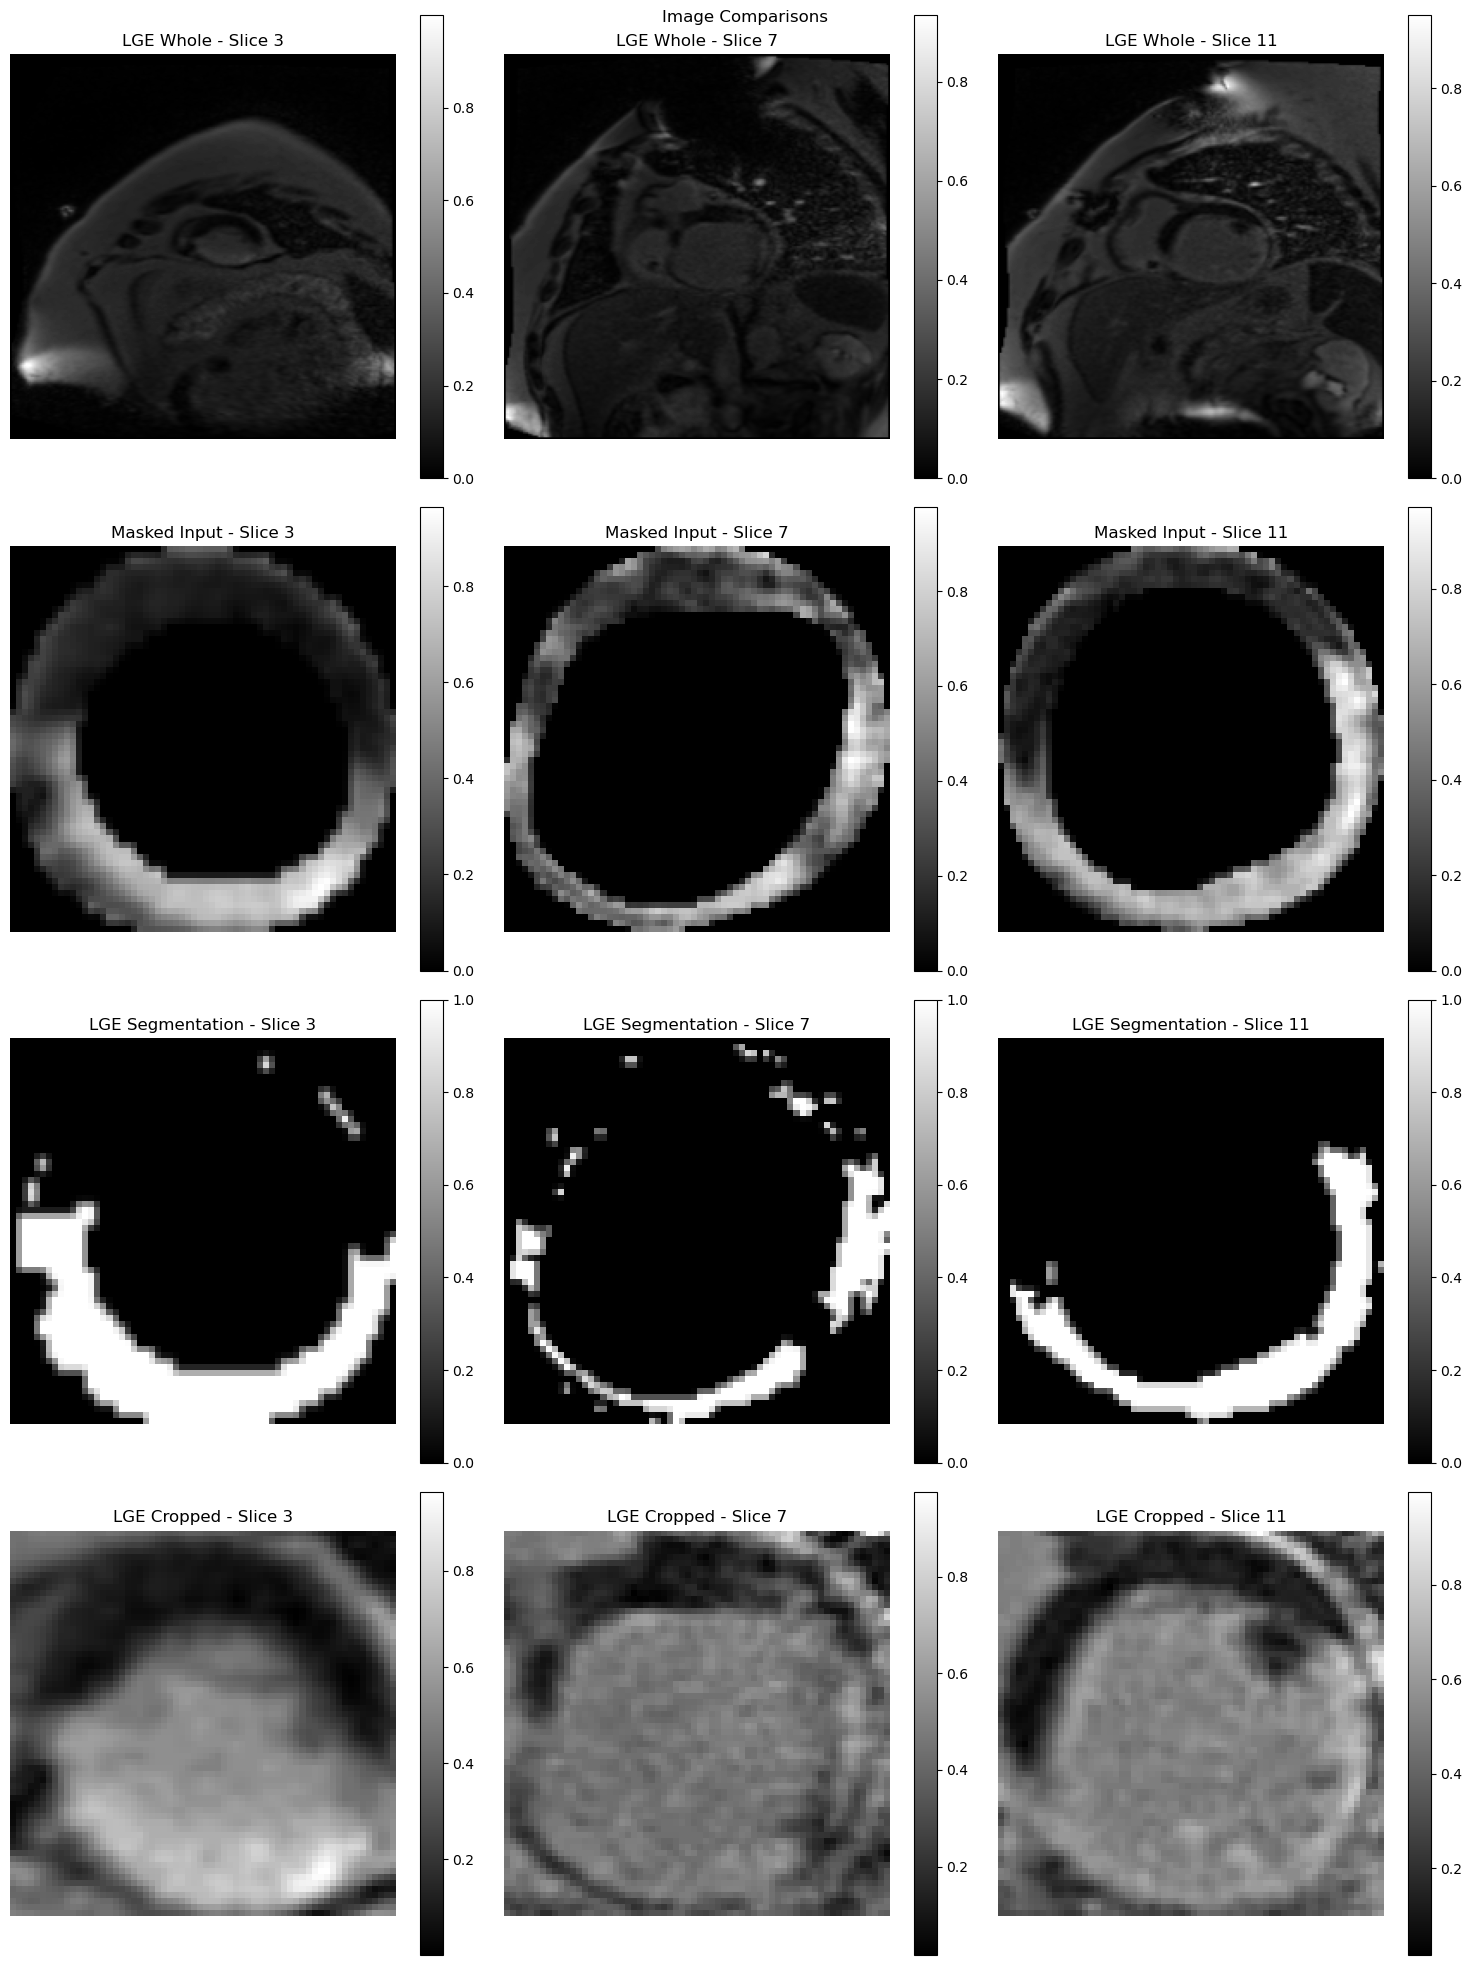

In [43]:
lge_whole= np.array(inf_data['lge_whole']).reshape(15,224,224)
x = np.array(inf_data['masked_input']).reshape(15,64,64)
y = np.array(inf_data['lge_seg']).reshape(15,64,64)
cropped = np.array(inf_data['lge_cropped']).reshape(15,64,64)


fig, axes = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Image Comparisons')

# Select 3 sample slices to display
sample_slices = [3, 7, 11] 

arrays = {
    'LGE Whole': lge_whole,
    'Masked Input': x,
    'LGE Segmentation': y,
    'LGE Cropped': cropped
}

for row, (title, data) in enumerate(arrays.items()):
    for col, slice_idx in enumerate(sample_slices):
        ax = axes[row, col]
        im = ax.imshow(data[slice_idx], cmap='gray')
        ax.set_title(f'{title} - Slice {slice_idx}')
        ax.axis('off')
        fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()